### Playing GAME 2048 using trained weights



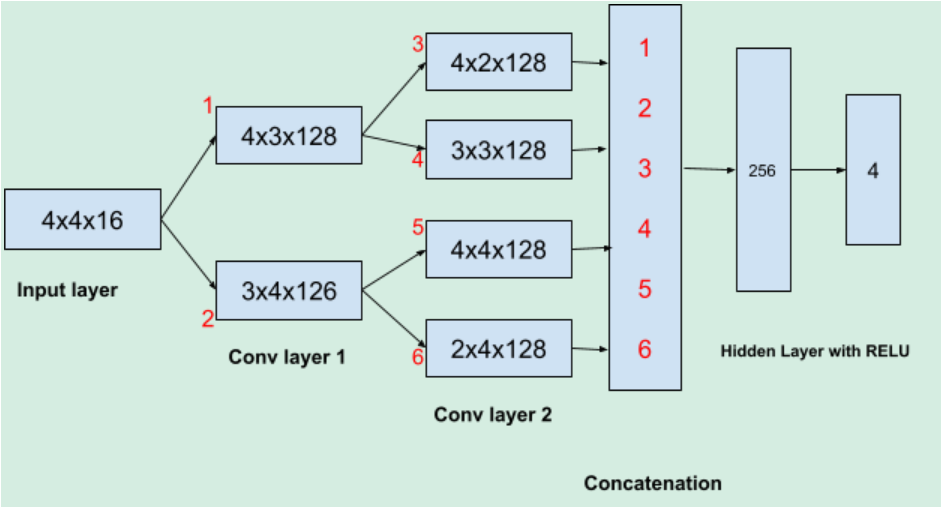

### Import Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!sudo apt-get install python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:

import numpy as np
from copy import deepcopy
import random 
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
final_weights=dict()

In [ ]:
#conv layer1 depth
depth1 = 128

#conv layer2 depth
depth2 = 128

#input depth
input_units = 16

#fully conneted hidden layer
hidden_units = 256

#output layer
output_units = 4

#shape of weights
conv1_layer1_shape = [2,1,input_units ,depth1]
conv1_layer2_shape = [2,1,depth1,depth2]
conv2_layer1_shape = [1,2,input_units ,depth1]
conv2_layer2_shape = [1,2,depth1,depth2]

fc_layer1_w_shape = [3*4*depth1*2+ 4*2*depth2*2 + 3*3*depth2*2,hidden_units]
fc_layer1_b_shape = [hidden_units]
fc_layer2_w_shape = [hidden_units,output_units]
fc_layer2_b_shape = [output_units]

### Restoring the Final Weights stored in CSV

In [ ]:
path = r'/content/gdrive/Shareddrives/CMPE_260/Tamanna_DQN/Final_Weights'
final_weights['conv1_layer1'] = np.array(pd.read_csv(path + r'\conv1_layer1_weights.csv')['Weight']).reshape(conv1_layer1_shape)
final_weights['conv1_layer2'] = np.array(pd.read_csv(path + r'\conv1_layer2_weights.csv')['Weight']).reshape(conv1_layer2_shape)
final_weights['conv2_layer1'] = np.array(pd.read_csv(path + r'\conv2_layer1_weights.csv')['Weight']).reshape(conv2_layer1_shape)
final_weights['conv2_layer2'] = np.array(pd.read_csv(path + r'\conv2_layer2_weights.csv')['Weight']).reshape(conv2_layer2_shape)
final_weights['fc_layer1_w'] = np.array(pd.read_csv(path + r'\fc_layer1_weights.csv')['Weight']).reshape(fc_layer1_w_shape)
final_weights['fc_layer1_b'] = np.array(pd.read_csv(path + r'\fc_layer1_biases.csv')['Weight']).reshape(fc_layer1_b_shape)
final_weights['fc_layer2_w'] = np.array(pd.read_csv(path + r'\fc_layer2_weights.csv')['Weight']).reshape(fc_layer2_w_shape)
final_weights['fc_layer2_b'] = np.array(pd.read_csv(path + r'\fc_layer2_biases.csv')['Weight']).reshape(fc_layer2_b_shape)

### Defining the Logic of Game

In [ ]:
#initialize a new game matrix  of zixe n*n
def new_game(n):
    matrix = np.zeros([n,n])
    return matrix

#add 2 or 4 in the matrix
def add_two(m):
    empty_cells = []
    for i in range(len(m)):
        for j in range(len(m[0])):
            if(m[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return m
    
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
  
    prob = random.random()
    if(prob>=0.9):
        m[index_pair[0]][index_pair[1]]=4
    else:
        m[index_pair[0]][index_pair[1]]=2
    return m

#to check state of the game
def check_game_state(mat):
    #if 2048 in mat:
    #    return 'win'
    
    for i in range(len(mat)-1): #intentionally reduced to check the row on the right and below
        for j in range(len(mat[0])-1): #more elegant to use exceptions but most likely this will be their solution
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'Game not over'
            
    for i in range(len(mat)): #check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'Game not over'
            
    for k in range(len(mat)-1): #to check the left/right entries on the last row
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'Game not over'
        
    for j in range(len(mat)-1): #check up/down entries on last column
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'Game not over'
        
    return 'lose'


def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
            
    return np.transpose(mat)

def cover_up(mat):
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count] = mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return (new,done)


#up move
def up(game):
        game = transpose(game)
        game,done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        return (game,done,temp[2])
#left move
def left(game):
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        return (game,done,temp[2])

#down move
def down(game):
        game=reverse(transpose(game))
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(reverse(game))
        return (game,done,temp[2])

#right move
def right(game):
        game=reverse(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=reverse(game)
        return (game,done,temp[2])

# Merge when two neighboring cells have the same value       
def merge(mat):
    done=False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                mat[i][j]*=2
                score += mat[i][j]   
                mat[i][j+1]=0
                done=True
    return (mat,done,score)


### Controls

In [ ]:
# Defining the dictionary for UP,DOWN, LEFT,RIGHT arrow movement
controls = {0:up,1:left,2:right,3:down}

### Important Functions
* Creating Empty Cell Function (Used in Reward)
* Convert Input Values of Matrix to power of 2

In [ ]:
#convert the input game matrix into corresponding power of 2 matrix.
def change_values(X):
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][i][j][power] = 1.0
    return power_mat        

#find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

## Building Model Architecture and using Trained Weights for Kernel initialization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v1 as tf


learned_graph = tf.Graph()

with learned_graph.as_default():
#input data
 
  input_data = tf.compat.v1.placeholder(tf.float32,shape=(1,4,4,16))

  def conv1_layer1_weights(shape=(), dtype=None):
    return final_weights['conv1_layer1']
  def conv2_layer1_weights(shape=(), dtype=None):
    return final_weights['conv2_layer1']
  def conv1_layer2_weights(shape=(), dtype=None):
    return final_weights['conv1_layer2']
  def conv2_layer2_weights(shape=(), dtype=None):
    return final_weights['conv2_layer2']


  def make_model(input_shape):
    #Input
    input=keras.Input(shape=input_shape[1:] ,name='input',batch_size=input_shape[0])
 
    #layer1    

    x=layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv1",kernel_initializer= conv1_layer1_weights)(input)
    y1=layers.Activation("relu")(x)
    y2=layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv2",kernel_initializer=conv2_layer1_weights)(input)
    y3=layers.Activation("relu")(y2)

   #layer2
    y4=tf.keras.layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv11",kernel_initializer=conv1_layer2_weights)(y1)
    y5=layers.Activation("relu")(y4)
    y6=tf.keras.layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv12",kernel_initializer=conv2_layer2_weights)(y1)
    y7=layers.Activation("relu")(y6)
    y8=tf.keras.layers.Conv2D(kernel_size=(2,1),filters=128,strides=1,padding="valid",name="conv21",kernel_initializer=conv1_layer2_weights)(y3)
    y9=layers.Activation("relu")(y8)
    y10=tf.keras.layers.Conv2D(kernel_size=(1,2),filters=128,strides=1,padding="valid",name="conv22",kernel_initializer=conv2_layer2_weights)(y3)
    y11=layers.Activation("relu")(y10)

    #get shapes of all activations
    shape1 = y1.shape.as_list()
    shape2 = y3.shape.as_list()
    shape11 = y5.shape.as_list()
    shape12 = y7.shape.as_list()
    shape21 = y9.shape.as_list()
    shape22 = y11.shape.as_list()
  
    #expansion
    hidden1 = tf.reshape(y1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
    hidden2 = tf.reshape(y3,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
    hidden11 = tf.reshape(y5,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
    hidden12 = tf.reshape(y7,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
    hidden21 = tf.reshape(y9,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
    hidden22 = tf.reshape(y11,[shape22[0],shape22[1]*shape22[2]*shape22[3]])
 
    #concatenation
    hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)

    #full connected layers
    # hidden=layers.Dense(units=256,kernel_initializer=fc_layer1_weights,bias_initializer=fc_layer1_biases,activation="relu")(hidden)
    hidden=layers.Dense(units=256,activation="relu")(hidden)
    
    #output layer

    output=layers.Dense(4,activation=None)(hidden)
  
    return keras.Model(input,output)


  model1=make_model(input_shape=(1, 4, 4, 16))
  # model2=make_model(input_shape=(512, 4, 4, 16))

# Model prediction for single example
  single_output = model1(input_data)

# # Model prediction for batch data
# logits = model2(tf_batch_dataset)



In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(1, 4, 4, 16)]      0           []                               
                                                                                                  
 conv1 (Conv2D)                 (1, 3, 4, 128)       4224        ['input[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (1, 4, 3, 128)       4224        ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (1, 3, 4, 128)       0           ['conv1[0][0]']                  
                                                                                              

In [ ]:

from tkinter import Frame
SIZE = 300
GRID_LEN = 4
GRID_PADDING = 10

BACKGROUND_COLOR_GAME = "#92877d"
BACKGROUND_COLOR_CELL_EMPTY = "#9e948a"
BACKGROUND_COLOR_DICT = {   2:"#eee4da", 4:"#ede0c8", 8:"#f2b179", 16:"#f59563", \
                            32:"#f67c5f", 64:"#f65e3b", 128:"#edcf72", 256:"#edcc61", \
                            512:"#edc850", 1024:"#edc53f", 2048:"#edc22e" }

CELL_COLOR_DICT = { 2:"#776e65", 4:"#776e65", 8:"#f9f6f2", 16:"#f9f6f2", \
                    32:"#f9f6f2", 64:"#f9f6f2", 128:"#f9f6f2", 256:"#f9f6f2", \
                    512:"#f9f6f2", 1024:"#f9f6f2", 2048:"#f9f6f2" }

FONT = ("Verdana", 40, "bold")

learned_sess = tf.Session(graph=learned_graph)

class GameGrid(Frame):
    def __init__(self):
        Frame.__init__(self)

        self.grid()
        self.master.title('2048')

        self.grid_cells = []
        self.init_grid()
        self.init_matrix()
        self.update_grid_cells()
        
        self.wait_visibility()
        self.after(10,self.make_move)
        
    def init_grid(self):
        background = Frame(self, bg=BACKGROUND_COLOR_GAME, width=SIZE, height=SIZE)
        background.grid()
        for i in range(GRID_LEN):
            grid_row = []
            for j in range(GRID_LEN):
                cell = Frame(background, bg=BACKGROUND_COLOR_CELL_EMPTY, width=SIZE/GRID_LEN, height=SIZE/GRID_LEN)
                cell.grid(row=i, column=j, padx=GRID_PADDING, pady=GRID_PADDING)
                # font = Font(size=FONT_SIZE, family=FONT_FAMILY, weight=FONT_WEIGHT)
                t = Label(master=cell, text="", bg=BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT, width=4, height=2)
                t.grid()
                grid_row.append(t)

            self.grid_cells.append(grid_row)

    def gen(self):
        return randint(0, GRID_LEN - 1)

    def init_matrix(self):
        self.matrix = new_game(4)

        self.matrix=add_two(self.matrix)
        self.matrix=add_two(self.matrix)

    def update_grid_cells(self):
        for i in range(GRID_LEN):
            for j in range(GRID_LEN):
                new_number = self.matrix[i][j]
                if new_number == 0:
                    self.grid_cells[i][j].configure(text="", bg=BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(text=str(new_number), bg=BACKGROUND_COLOR_DICT[new_number], fg=CELL_COLOR_DICT[new_number])
        self.update_idletasks()
        
    def make_move(self):
        output = learned_sess.run([single_output],feed_dict = {single_dataset:change_values(self.matrix)})
        move = np.argmax(output[0])
        self.matrix,done,tempo = controls[move](self.matrix)
        done=True
        
     
        if check_game_state(self.matrix)=='lose':
            self.grid_cells[1][1].configure(text="You",bg=BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!",bg=BACKGROUND_COLOR_CELL_EMPTY)
            done=False
            
        self.matrix = add_two(self.matrix)
        self.update_grid_cells()
        
        
        if(done==True):
            self.after(7,self.make_move)
        else:
            time.sleep(3)
            self.init_matrix()
            self.update_grid_cells()
            self.after(7,self.make_move)

    def generate_next(self):
        empty_cells = []
        for i in range(len(mat)):
            for j in range(len(mat)):
                if(mat[i][j]==0):
                    empty_cells.append((i,j))
        if(len(empty_cells)==0):
            return 0,false
        index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
        index = index_pair
        self.matrix[index[0]][index[1]] = 2

root = Tk()
gamegrid = GameGrid()
root.mainloop()